# Dataset Exploration

## Imports

In [47]:
import matplotlib.pyplot as plt
from pathlib import Path
import os
import cv2
from PIL import Image
import pandas as pd
import random
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import numpy as np

## EDA

In [17]:
DATASET_PATH = Path('../dataset/Data')

train_df = pd.read_csv(DATASET_PATH / 'train_paths.csv')
valid_df = pd.read_csv(DATASET_PATH / 'valid_paths.csv')
test_df = pd.read_csv(DATASET_PATH / 'test_paths.csv')

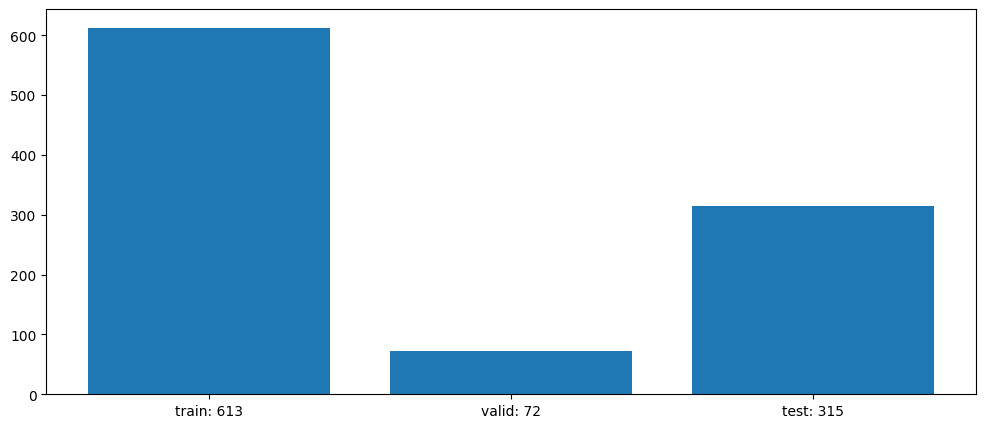

In [3]:
df_lens = [len(train_df), len(valid_df), len(test_df)]
plt.figure(figsize=(12, 5))
plt.bar([f'train: {len(train_df)}', f'valid: {len(valid_df)}', f'test: {len(test_df)}'], df_lens)
plt.show()

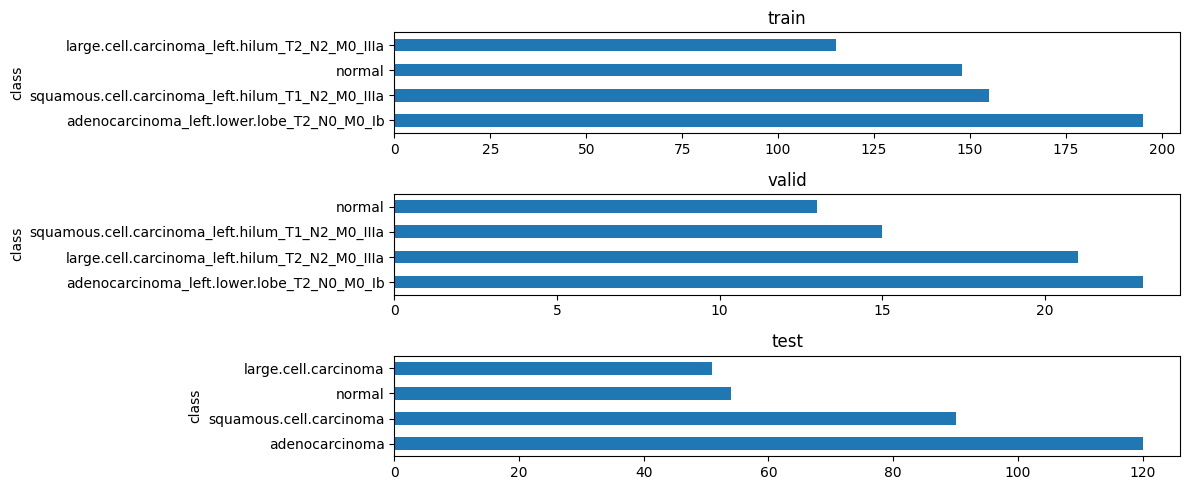

In [4]:
plt.figure(figsize=(12, 5))

plt.subplot(3, 1, 1)
plt.title('train')
train_df['class'].value_counts().plot(kind='barh')
plt.tight_layout()
# plt.show()
plt.subplot(3, 1, 2)
plt.title('valid')
valid_df['class'].value_counts().plot(kind='barh')
plt.tight_layout()
# plt.show()
plt.subplot(3, 1, 3)
plt.title('test')
test_df['class'].value_counts().plot(kind='barh')
plt.tight_layout()
plt.show()

> The class distribution on the training dataset is not balanced but it should be fine since we're using traditional methods. It seems that a lot of people that are in the dataset suffer from adenocarcinoma

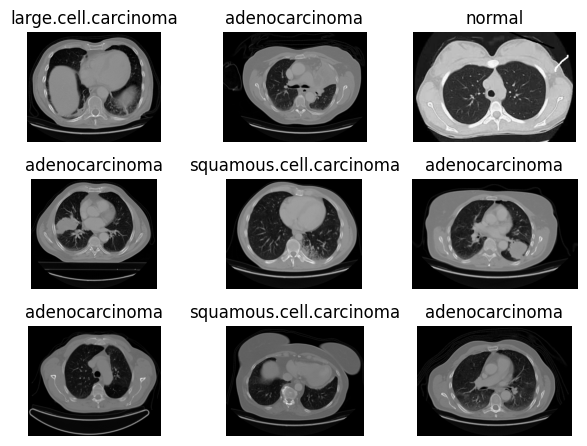

In [45]:
# 9 Random Images so we can know the dataset better

for i in range(9):
    random_data = random.choice(test_df.values)
    random_img = Image.open(random_data[0])
    random_label = random_data[1]
    plt.subplot(3, 3, i+1)
    plt.title(random_label)
    plt.imshow(random_img)
    plt.tight_layout()
    plt.axis(False)
plt.show()

# Checking which method is appropriate in using for this problem

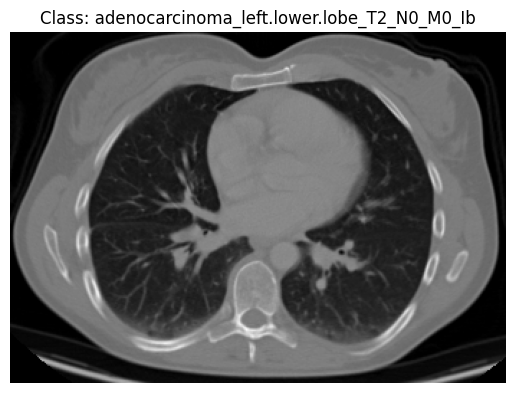

In [61]:
random_data = random.choice(train_df.values)
ORIGINAL_IMAGE = cv2.imread(random_data[0])
plt.title(f'Class: {random_data[1]}')
plt.imshow(ORIGINAL_IMAGE)
plt.axis(False)
plt.show()

## 1. Noise Reduction

The images itself don't have a lot of noise which won't be a problem. But some of the images have a little of grain noise, we might just use median filtering rather than gaussian since gaussian include blurring into the image and we might lose important features of the images. 

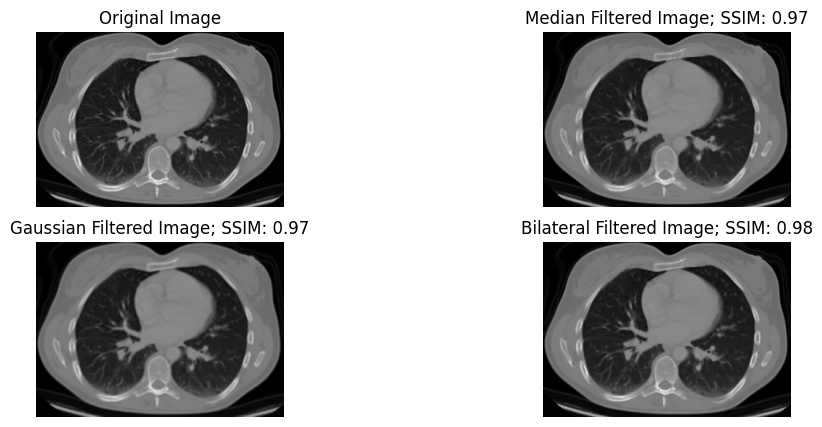

In [64]:
median_filtered_image = cv2.medianBlur(ORIGINAL_IMAGE, ksize=3)
gaussian_filtered_image = cv2.GaussianBlur(ORIGINAL_IMAGE, ksize=(3, 3), sigmaX=1)
bilateral_filtered_image = cv2.bilateralFilter(ORIGINAL_IMAGE, d=3, sigmaColor=75, sigmaSpace=75)

# comparing the original image with the denoised ones using ssim
'''
How to interpret SSIM:
- an SSIM value of 1.0 indicates perfect structural simlarity
- an SSIM value of 0.0 indicates no structural similarity
- negative values (super rare) indicates that the image have opposing structures
'''

# we set channel axis to 2 since we have 3 channels [0, 1, 2]
median_ssim_value, median_ssim_map = ssim(ORIGINAL_IMAGE, 
                                          median_filtered_image, 
                                          full=True,
                                          channel_axis=2)

gaussian_ssim_value, gaussian_ssim_map = ssim(ORIGINAL_IMAGE, 
                                              gaussian_filtered_image, 
                                              full=True,
                                              channel_axis=2)

bilateral_ssim_value, bilateral_ssim_map = ssim(ORIGINAL_IMAGE, 
                                              bilateral_filtered_image, 
                                              full=True,
                                              channel_axis=2)

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(ORIGINAL_IMAGE)
plt.axis(False)

plt.subplot(2, 2, 2)
plt.title(f'Median Filtered Image; SSIM: {median_ssim_value:.2f}')
plt.imshow(median_filtered_image)
plt.axis(False)

plt.subplot(2, 2, 3)
plt.title(f'Gaussian Filtered Image; SSIM: {gaussian_ssim_value:.2f}')
plt.imshow(gaussian_filtered_image)
plt.axis(False)

plt.subplot(2, 2, 4)
plt.title(f'Bilateral Filtered Image; SSIM: {bilateral_ssim_value:.2f}')
plt.imshow(bilateral_filtered_image)
plt.axis(False)

plt.savefig('filter_comparison.jpg')
plt.show()

> Basically we want something that removes the noise but also keeps the important features. In this case I guess they're all kinda similar in the terms of retained information. But gaussian filter seems to lose more information than the others. In this case we can experiment for either median or bilateral. They seem to work quite good

## 2. Edge Detection

I will be judging which to use based on the information it has and how much noise it has

### Bilateral Filtered

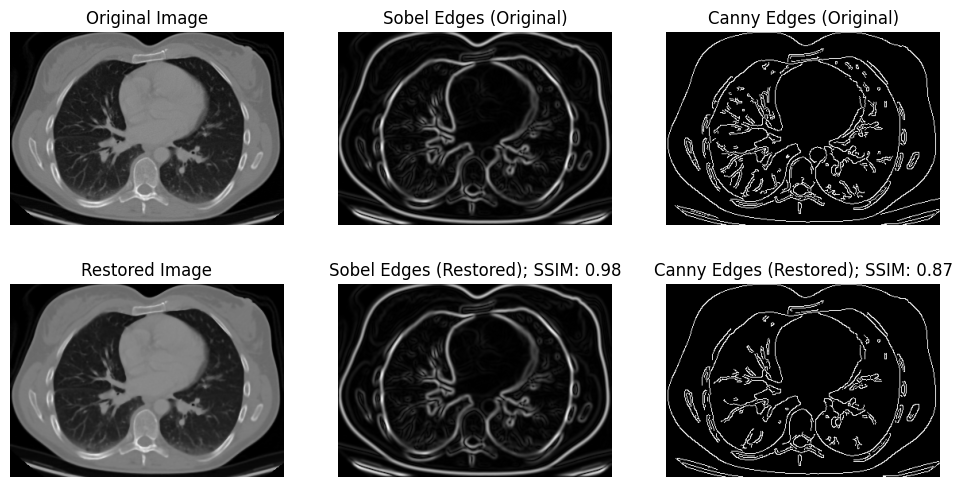

In [69]:
# Convert images to grayscale for edge detection
original_gray = cv2.cvtColor(ORIGINAL_IMAGE, cv2.COLOR_RGB2GRAY)
restored_gray = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_RGB2GRAY)

# Apply Sobel Edge Detection to both images
sobel_x_original = cv2.Sobel(original_gray, cv2.CV_64F, 1, 0, ksize=11)
sobel_y_original = cv2.Sobel(original_gray, cv2.CV_64F, 0, 1, ksize=11)
sobel_edges_original = cv2.magnitude(sobel_x_original, sobel_y_original)

sobel_x_restored = cv2.Sobel(restored_gray, cv2.CV_64F, 1, 0, ksize=11)
sobel_y_restored = cv2.Sobel(restored_gray, cv2.CV_64F, 0, 1, ksize=11)
sobel_edges_restored = cv2.magnitude(sobel_x_restored, sobel_y_restored)

# Apply Canny Edge Detection to both images
canny_edges_original = cv2.Canny(original_gray, 50, 150)
canny_edges_restored = cv2.Canny(restored_gray, 50, 150)

# Calculate PSNR and SSIM between the edge-detected images
sobel_ssim = ssim(sobel_edges_original, sobel_edges_restored, data_range=255)

canny_ssim = ssim(canny_edges_original, canny_edges_restored, data_range=255)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(ORIGINAL_IMAGE)
plt.title("Original Image")
plt.axis(False)

plt.subplot(2, 3, 2)
plt.imshow(sobel_edges_original, cmap='gray')
plt.title("Sobel Edges (Original)")
plt.axis(False)

plt.subplot(2, 3, 3)
plt.imshow(canny_edges_original, cmap='gray')
plt.title("Canny Edges (Original)")
plt.axis(False)

plt.subplot(2, 3, 4)
plt.imshow(bilateral_filtered_image)
plt.title("Restored Image")
plt.axis(False)

plt.subplot(2, 3, 5)
plt.imshow(sobel_edges_restored, cmap='gray')
plt.title(f"Sobel Edges (Restored); SSIM: {sobel_ssim:.2f}")
plt.axis(False)

plt.subplot(2, 3, 6)
plt.imshow(canny_edges_restored, cmap='gray')
plt.title(f"Canny Edges (Restored); SSIM: {canny_ssim:.2f}")
plt.axis(False)

plt.show()

### Median Filtered

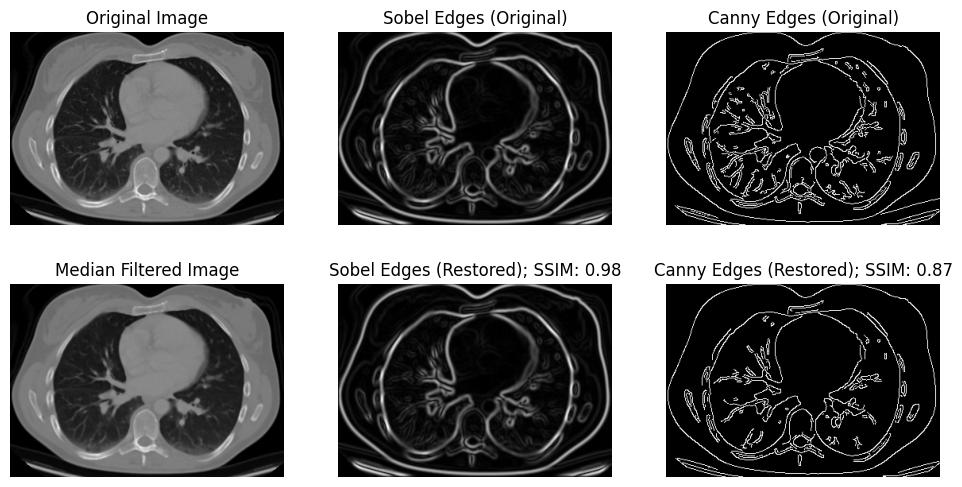

In [68]:
# Convert images to grayscale for edge detection
original_gray = cv2.cvtColor(ORIGINAL_IMAGE, cv2.COLOR_RGB2GRAY)
restored_gray = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_RGB2GRAY)

# Apply Sobel Edge Detection to both images
sobel_x_original = cv2.Sobel(original_gray, cv2.CV_64F, 1, 0, ksize=11)
sobel_y_original = cv2.Sobel(original_gray, cv2.CV_64F, 0, 1, ksize=11)
sobel_edges_original = cv2.magnitude(sobel_x_original, sobel_y_original)

sobel_x_restored = cv2.Sobel(restored_gray, cv2.CV_64F, 1, 0, ksize=11)
sobel_y_restored = cv2.Sobel(restored_gray, cv2.CV_64F, 0, 1, ksize=11)
sobel_edges_restored = cv2.magnitude(sobel_x_restored, sobel_y_restored)

# Apply Canny Edge Detection to both images
canny_edges_original = cv2.Canny(original_gray, 50, 150)
canny_edges_restored = cv2.Canny(restored_gray, 50, 150)

# Calculate PSNR and SSIM between the edge-detected images
sobel_ssim = ssim(sobel_edges_original, sobel_edges_restored, data_range=255)

canny_ssim = ssim(canny_edges_original, canny_edges_restored, data_range=255)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(ORIGINAL_IMAGE)
plt.title("Original Image")
plt.axis(False)

plt.subplot(2, 3, 2)
plt.imshow(sobel_edges_original, cmap='gray')
plt.title("Sobel Edges (Original)")
plt.axis(False)

plt.subplot(2, 3, 3)
plt.imshow(canny_edges_original, cmap='gray')
plt.title("Canny Edges (Original)")
plt.axis(False)

plt.subplot(2, 3, 4)
plt.imshow(median_filtered_image)
plt.title("Median Filtered Image")
plt.axis(False)

plt.subplot(2, 3, 5)
plt.imshow(sobel_edges_restored, cmap='gray')
plt.title(f"Sobel Edges (Restored); SSIM: {sobel_ssim:.2f}")
plt.axis(False)

plt.subplot(2, 3, 6)
plt.imshow(canny_edges_restored, cmap='gray')
plt.title(f"Canny Edges (Restored); SSIM: {canny_ssim:.2f}")
plt.axis(False)

plt.show()

> Well it seems that they don't have that much of a difference between Bilateral and Median so maybe we'll experiment with the model for later. For the edge detection, I think the one that might do better is probably Sobel since in deciding cancer types we would typically need a lot more features but maybe we'll see how it goes on the experimentation later

## Feature Detection 

In [106]:
# Compute the histogram of Sobel edge magnitudes
sobel_hist, _ = np.histogram(sobel_edges_original.ravel(), bins=256, range=(0, 255), density=True)

# Example: Normalizing the histogram
sobel_hist = sobel_hist / np.sum(sobel_hist)

In [108]:
from scipy.stats import skew, kurtosis

# Compute statistical features
mean_edge = np.mean(sobel_edges_original)
std_edge = np.std(sobel_edges_original)
skew_edge = skew(sobel_edges_original.ravel())
kurtosis_edge = kurtosis(sobel_edges_original.ravel())

sobel_features = [mean_edge, std_edge, skew_edge, kurtosis_edge]

In [109]:
from skimage.feature import graycomatrix, graycoprops

# Convert Sobel edges to uint8 (required for graycomatrix)
sobel_edges_uint8 = np.uint8(sobel_edges_original / np.max(sobel_edges_original) * 255)

# Compute gray-level co-occurrence matrix
glcm = graycomatrix(sobel_edges_uint8, distances=[1], angles=[0], levels=256)

# Extract Haralick features
contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

texture_features = [contrast, correlation, energy, homogeneity]

In [110]:
# Detect keypoints and compute descriptors using ORB
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(np.uint8(sobel_edges_original), None)

# Example: Use descriptors directly as features
if descriptors is not None:
    features = descriptors.flatten()  # Flatten to a single feature vector
else:
    features = np.zeros(32)  # Handle case with no descriptors

In [111]:
# Combine histogram, statistical features, and texture features
features = np.concatenate([sobel_hist, sobel_features, texture_features])

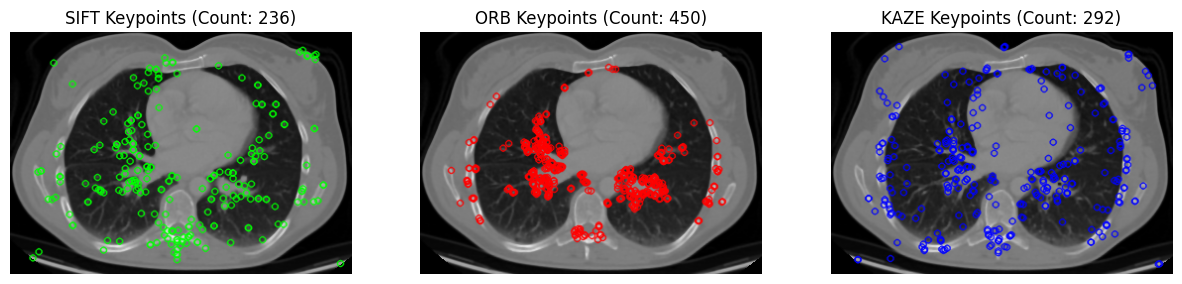

In [115]:
# Methods to use: ORB, SIFT, KAZE
orb = cv2.ORB_create()
sift = cv2.SIFT_create()
kaze = cv2.KAZE_create()  

# Detect keypoints and descriptors
keypoints_sift, descriptors_sift = sift.detectAndCompute(restored_gray, None)
keypoints_orb, descriptors_orb = orb.detectAndCompute(restored_gray, None)
keypoints_kaze, descriptors_kaze = kaze.detectAndCompute(restored_gray, None)

# Draw keypoints on the image
image_sift = cv2.drawKeypoints(restored_gray, keypoints_sift, None, color=(0, 255, 0))
image_orb = cv2.drawKeypoints(restored_gray, keypoints_orb, None, color=(255, 0, 0))
image_kaze = cv2.drawKeypoints(restored_gray, keypoints_kaze, None, color=(0, 0, 255))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_sift)
plt.title(f"SIFT Keypoints (Count: {len(keypoints_sift)})")
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(image_orb)
plt.title(f"ORB Keypoints (Count: {len(keypoints_orb)})")
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(image_kaze)
plt.title(f"KAZE Keypoints (Count: {len(keypoints_kaze)})")
plt.axis(False)

plt.show()

> KAZE looks really good, we can also use SIFT in combination